In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
results = glob.glob("../nextflow/results/*")[-1]
results

'../nextflow/results/2022-03-28'

In [3]:
date = "2022-03-22"

def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 74 GC trees


In [4]:
df = pd.DataFrame()

for row, (mouse_gc, tree) in enumerate(trees.items()):
    mouse, gc = mouse_gc.split("_")
    mouse = mouse.lstrip("mouse")
    if mouse in ("7", "8"):
        print(f"skipping 10-week {mouse_gc}")
        continue
#     if sum(node.abundance for node in tree.tree.traverse()) < 20:
#         print(f"skipping low-abundance {mouse_gc}")
#         continue
    
    gc = gc.lstrip("GC")
    df.loc[row, "mouse"] = mouse
    df.loc[row, "GC"] = gc
    
    abundances = np.array([node.abundance for node in tree.tree.traverse()])

    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in tree.tree.children]
    df.loc[row, "total abundance"] = sum(abundances)
    df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)

    df.loc[row, f"max LBI"] = np.nanmax([node.LBI for node in tree.tree.traverse()])
    df.loc[row, f"max LBR"] = np.nanmax([node.LBR for node in tree.tree.traverse()])

    # note: additive delta_bind for now
    delta_bind_dat = []
    for node in tree.tree.traverse():
        if not np.isnan(node.delta_bind):
            for _ in range(node.abundance):
                delta_bind_dat.append(node.delta_bind)
    df.loc[row, "95th percentile delta_bind"] = np.percentile(delta_bind_dat, 95)
    
df

skipping 10-week mouse7_GC90
skipping 10-week mouse8_GC84
skipping 10-week mouse8_GC85
skipping 10-week mouse8_GC86
skipping 10-week mouse8_GC87
skipping 10-week mouse8_GC88
skipping 10-week mouse8_GC89


,mouse,GC,total abundance,normalized dominance score,max LBI,max LBR,95th percentile delta_bind
0,1,1,89.0,0.932584,18.789397,4.572412,1.260416
1,1,2,72.0,0.958333,22.944806,10.325907,1.450151
2,1,3,84.0,0.833333,15.535093,11.257937,1.277015
3,1,4,75.0,0.626667,24.779330,3.565568,1.654111
4,1,5,84.0,0.785714,29.827268,6.591931,1.381599
...,...,...,...,...,...,...,...
62,5,83,78.0,0.441558,23.506305,2.350931,1.196820
63,6,74,78.0,0.884615,23.935277,9.933529,1.395440
64,6,75,70.0,0.971429,25.611653,4.754441,1.171988
65,6,76,81.0,0.592593,17.765943,8.617168,1.077752


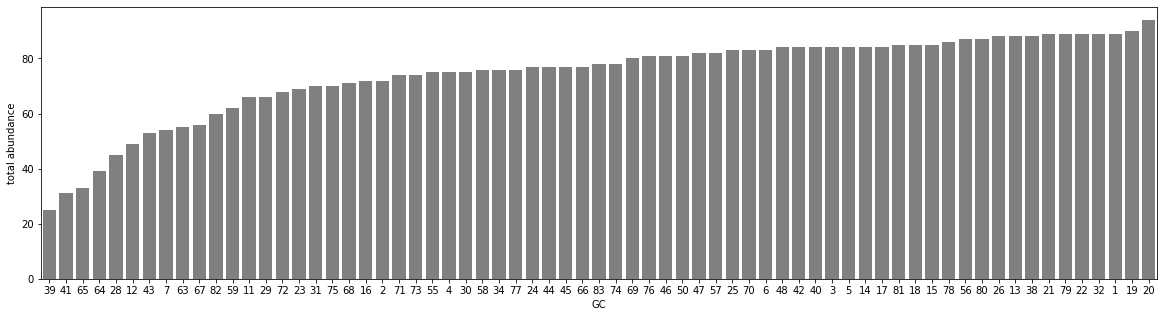

In [5]:
plt.figure(figsize=(20, 5))
sns.barplot(data=df.sort_values("total abundance"), x="GC", y="total abundance", color="grey")
plt.show()

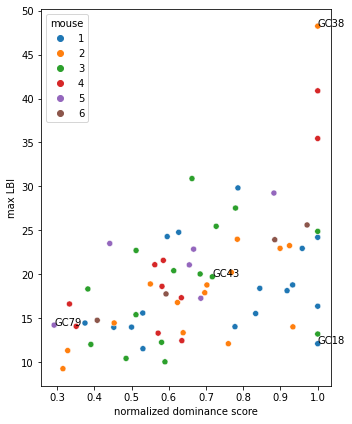

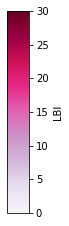

In [6]:
cmap = "PuRd"
vmin = 0
vmax = 30

fig = plt.figure(figsize=(5, 6))
sns.scatterplot(data=df, x="normalized dominance score", y="max LBI", hue="mouse", clip_on=False)
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", "max LBI"]]
    if (x == 1 and (y > 45 or y < 13)) or x < 0.3 or ((.7 < x < .75) and (19 < y < 21)):
        plt.annotate(f"GC{row.GC}", [x, y])
        key = f"mouse{row.mouse}_GC{row.GC}"
        colormap = trees[key].feature_colormap("LBI", vmin=vmin, vmax=vmax, cmap=cmap)
        trees[key].render(f"output/plots/NDS_LBI.{key}.svg", colormap=colormap, scale=20, branch_margin=-8)
plt.tight_layout()
plt.savefig("output/plots/NDS_LBI.pdf")
plt.show()
fig = plt.figure()
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax)), cax=cax, label="LBI")
plt.savefig("output/plots/NDS_LBI.cbar.pdf")
plt.show()

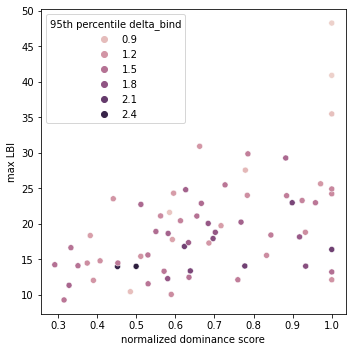

In [7]:
fig = plt.figure(figsize=(5, 5))
sns.scatterplot(data=df, x="normalized dominance score", y="max LBI", hue="95th percentile delta_bind", clip_on=False)
plt.tight_layout()
plt.show()